# Macroeconomic Forecasting Model with Sentiment Scores

#### Cell 7 to be updated, current result are wrong, just for testing.

### Loading Package

In [1]:
import numpy as np
import pandas as pd

### Reading in Macroeconomics Data

In [2]:
raw_US_gdp = pd.read_csv(r"Data\FRED\GDPC1.csv").set_index('DATE')
raw_US_inflation = pd.read_csv(r"Data\FRED\FPCPITOTLZGUSA.csv").set_index('DATE')
raw_US_unemployment = pd.read_csv(r"Data\FRED\UNRATE.csv").set_index('DATE')

In [3]:
raw_US_gdp.index = pd.to_datetime(raw_US_gdp.index)
raw_US_inflation.index = pd.to_datetime(raw_US_inflation.index)
raw_US_unemployment.index = pd.to_datetime(raw_US_unemployment.index)

In [4]:
data_US_unemployment = (raw_US_unemployment - raw_US_unemployment.shift(1))[1:]
data_US_unemployment['year'] = data_US_unemployment.index.year
data_US_unemployment['month'] = data_US_unemployment.index.month
data_US_unemployment = data_US_unemployment.reset_index().set_index(['year','month']).drop(columns = ['DATE'])

In [5]:
data_US_growth = ((raw_US_gdp - raw_US_gdp.shift(1)) / raw_US_gdp)[1:]
data_US_growth['year'] = data_US_growth.index.year
data_US_growth['quarter'] = np.ceil(data_US_growth.index.month / 3).astype(int)
data_US_growth = data_US_growth.reset_index().set_index(['year','quarter']).drop(columns = ['DATE'])

In [6]:
data_US_inflation = (raw_US_inflation - raw_US_inflation.shift(1))[1:]
data_US_inflation['year'] = data_US_inflation.index.year
data_US_inflation = data_US_inflation.reset_index().set_index(['year']).drop(columns = ['DATE'])

### Reading in Sentiment Score Data

In [7]:
########## !!!!!!!!!!!! wrong csv file!
sentiment_score = pd.read_csv(r"Data\sentiment_score_wrong.csv").set_index(['year','month']).drop(columns=['exception'])

In [8]:
year1 = []
year4 = []
period4 = []
for i in range(1979, 2021):
    year1.append(i)
    for j in range(0, 4):
        year4.append(i)
        period4.append(j+1)

In [9]:
column_name = ['positive', 'neutral', 'negative']
sentiment_score_yearly = pd.DataFrame(np.zeros((len(year1), len(column_name))), index = year1, columns = column_name)
sentiment_score_yearly = sentiment_score_yearly.reset_index().rename(columns={"index": "year"}).set_index('year')
sentiment_score_quarterly = pd.DataFrame(np.zeros((len(year4), len(column_name))), index = [year4, period4], columns = column_name)
sentiment_score_quarterly = sentiment_score_quarterly.reset_index().rename(columns={"level_0": "year", "level_1": "quarter"}).set_index(['year','quarter'])

In [10]:
sentiment_score_monthly = sentiment_score
sentiment_score_monthly["sum"] = sentiment_score_monthly.sum(axis=1)
sentiment_score_monthly = sentiment_score_monthly.div(sentiment_score_monthly["sum"], axis=0).drop(columns=['sum'])

In [11]:
for year in sentiment_score_yearly.index:
    sentiment_score_yearly.loc[year] = sentiment_score_monthly.loc[year].mean(axis=0)

In [12]:
for (year,quarter) in sentiment_score_quarterly.index:
    year_match = sentiment_score_monthly.index.get_level_values('year') == year
    quarter_match = np.ceil(sentiment_score_monthly.index.get_level_values('month') / 3) == quarter
    sentiment_score_quarterly.loc[year, quarter] = sentiment_score_monthly[year_match * quarter_match].mean(axis=0)

### Combine the Datasets

In [13]:
data_withSentiment_US_unemployment = sentiment_score_monthly.join(data_US_unemployment)
data_withSentiment_US_growth = sentiment_score_quarterly.join(data_US_growth)
data_withSentiment_US_inflation = sentiment_score_yearly.join(data_US_inflation)

In [14]:
data_US_unemployment = data_withSentiment_US_unemployment.drop(columns = ['positive','neutral','negative'])
data_US_growth = data_withSentiment_US_growth.drop(columns = ['positive','neutral','negative'])
data_US_inflation = data_withSentiment_US_inflation.drop(columns = ['positive','neutral','negative'])

### Exploratory Data Analysis

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

P-value:  1.8019638493718278e-24


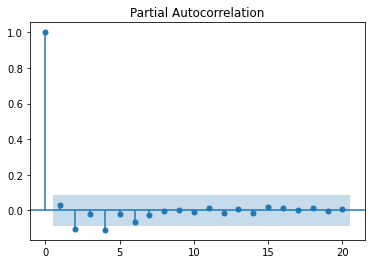

In [16]:
df = data_US_unemployment
stationarityTest_US_unemployment = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_unemployment[1])
pacf = plot_pacf(df, lags=20)

P-value:  2.0395551840158942e-25


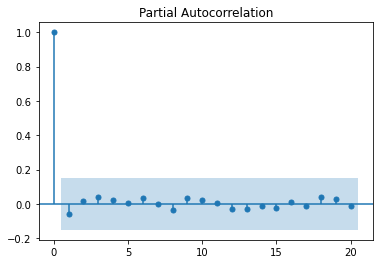

In [17]:
df = data_US_growth
stationarityTest_US_growth = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_growth[1])
pacf = plot_pacf(df, lags=20)

P-value:  0.00019913420128400285


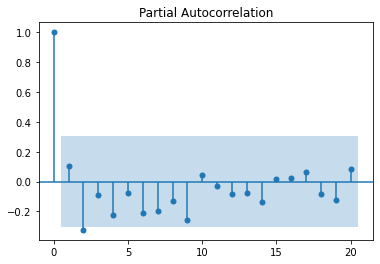

In [18]:
df = data_US_inflation
stationarityTest_US_inflation = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_inflation[1])
pacf = plot_pacf(df, lags=20)

### Baseline Model

In [19]:
import statsmodels.api as sm
#from statsmodels.tsa.ar_model import AutoReg

In [20]:
X = sm.add_constant(data_US_unemployment[0:-1].reset_index().drop(columns = ['year','month']))
Y = data_US_unemployment[1:].reset_index().drop(columns = ['year','month'])
ar_model_US_unemployment = sm.OLS(Y,X).fit()
print(ar_model_US_unemployment.summary())

#ar_model_US_unemployment = AutoReg(data_US_unemployment, lags=1).fit()
#print(ar_model_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4975
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.481
Time:                        01:24:26   Log-Likelihood:                -383.08
No. Observations:                 503   AIC:                             770.2
Df Residuals:                     501   BIC:                             778.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.023      0.067      0.9

In [21]:
X = sm.add_constant(data_US_growth[0:-1].reset_index().drop(columns = ['year','quarter']))
Y = data_US_growth[1:].reset_index().drop(columns = ['year','quarter'])
ar_model_US_growth = sm.OLS(Y,X).fit()
print(ar_model_US_growth.summary())

#ar_model_US_growth = AutoReg(data_US_growth, lags=1).fit()
#print(ar_model_US_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5285
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.468
Time:                        01:24:26   Log-Likelihood:                 505.61
No. Observations:                 167   AIC:                            -1007.
Df Residuals:                     165   BIC:                            -1001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.001      6.228      0.0

In [22]:
X = sm.add_constant(data_US_inflation[0:-1].reset_index().drop(columns = ['year']))
Y = data_US_inflation[1:].reset_index().drop(columns = ['year'])
ar_model_US_inflation = sm.OLS(Y,X).fit()
print(ar_model_US_inflation.summary())

#ar_model_US_inflation = AutoReg(data_US_inflation, lags=1).fit()
#print(ar_model_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.5056
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.481
Time:                        01:24:26   Log-Likelihood:                -73.683
No. Observations:                  41   AIC:                             151.4
Df Residuals:                      39   BIC:                             154.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2295      0.235     -0.

### Model with Sentiment Scores (previous quarter)

In [23]:
X = sm.add_constant(data_withSentiment_US_unemployment[0:-1].reset_index().drop(columns = ['year','month']))
Y = data_withSentiment_US_unemployment[1:].reset_index().drop(columns = ['year','month','positive','neutral','negative'])
ar_model_withSentiment_previous_US_unemployment = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_previous_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2316
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.874
Time:                        01:24:28   Log-Likelihood:                -382.98
No. Observations:                 503   AIC:                             774.0
Df Residuals:                     499   BIC:                             790.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.018      0.078      0.9

In [24]:
X = sm.add_constant(data_withSentiment_US_growth[0:-1].reset_index().drop(columns = ['year','quarter']))
Y = data_withSentiment_US_growth[1:].reset_index().drop(columns = ['year','quarter','positive','neutral','negative'])
ar_model_withSentiment_previous_US_growth = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_previous_US_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.3637
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.779
Time:                        01:24:29   Log-Likelihood:                 505.90
No. Observations:                 167   AIC:                            -1004.
Df Residuals:                     163   BIC:                            -991.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      6.203      0.0

In [25]:
X = sm.add_constant(data_withSentiment_US_inflation[0:-1].reset_index().drop(columns = ['year']))
Y = data_withSentiment_US_inflation[1:].reset_index().drop(columns = ['year','positive','neutral','negative'])
ar_model_withSentiment_previous_US_inflation = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_previous_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.594
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.207
Time:                        01:24:30   Log-Likelihood:                -71.455
No. Observations:                  41   AIC:                             150.9
Df Residuals:                      37   BIC:                             157.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1490      0.190     -0.

### Model with Sentiment Scores (current quarter)

In [26]:
X1 = data_withSentiment_US_unemployment.reset_index().drop(columns = ['year','month','positive','neutral','negative'])[0:-1]
X2 = data_withSentiment_US_unemployment[['positive','neutral','negative']][1:].reset_index().drop(columns = ['year','month'])
X = X1.join(X2)
Y = data_withSentiment_US_unemployment[1:].reset_index().drop(columns = ['year','month','positive','neutral','negative'])
ar_model_withSentiment_current_US_unemployment = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.912
Date:                Mon, 01 Nov 2021   Prob (F-statistic):             0.0340
Time:                        01:24:31   Log-Likelihood:                -378.97
No. Observations:                 503   AIC:                             765.9
Df Residuals:                     499   BIC:                             782.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UNRATE         0.0332      0.044      0.748      0.4

In [27]:
X1 = data_withSentiment_US_growth.reset_index().drop(columns = ['year','quarter','positive','neutral','negative'])[0:-1]
X2 = data_withSentiment_US_growth[['positive','neutral','negative']][1:].reset_index().drop(columns = ['year','quarter'])
X = X1.join(X2)
Y = data_withSentiment_US_growth[1:].reset_index().drop(columns = ['year','quarter','positive','neutral','negative'])
ar_model_withSentiment_current_US_growth = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_current_US_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4606
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.710
Time:                        01:24:32   Log-Likelihood:                 506.04
No. Observations:                 167   AIC:                            -1004.
Df Residuals:                     163   BIC:                            -991.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDPC1         -0.0686      0.080     -0.861      0.3

In [28]:
X1 = data_withSentiment_US_inflation.reset_index().drop(columns = ['year','positive','neutral','negative'])[0:-1]
X2 = data_withSentiment_US_inflation[['positive','neutral','negative']][1:].reset_index().drop(columns = ['year'])
X = X1.join(X2)
Y = data_withSentiment_US_inflation[1:].reset_index().drop(columns = ['year','positive','neutral','negative'])
ar_model_withSentiment_current_US_inflation = sm.OLS(Y,X).fit()
print(ar_model_withSentiment_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.007
Date:                Mon, 01 Nov 2021   Prob (F-statistic):              0.130
Time:                        01:24:33   Log-Likelihood:                -70.856
No. Observations:                  41   AIC:                             149.7
Df Residuals:                      37   BIC:                             156.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
FPCPITOTLZGUSA     0.1553      0.145      1.